In [5]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from utils import *

In [50]:
epoch = loadpkl('/data/xiaowei/social_network/HENU/preprocessing/C30_330_F8_14_N50_E2/final_eye_close_1001_epoch_concat.pkl')



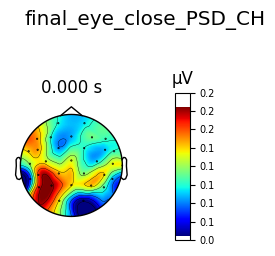

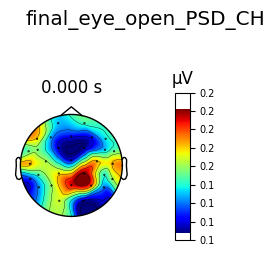

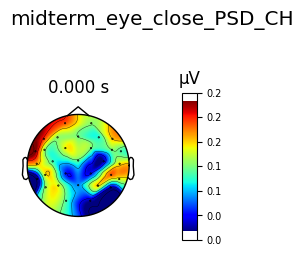

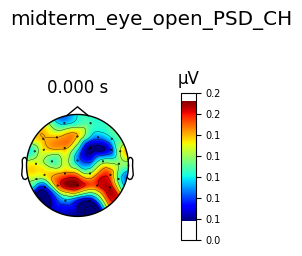

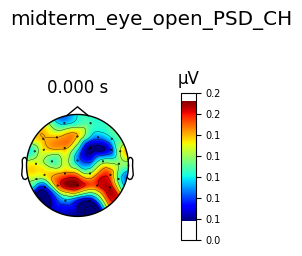

In [51]:
model = 'LinearRegression'
psd_r2 = pd.read_csv('/data/xiaowei/social_network/HENU/EEG_regression/C30_330_F8_14_N50_E2/' + model + '_r2_score.csv', index_col=0, header=0)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)


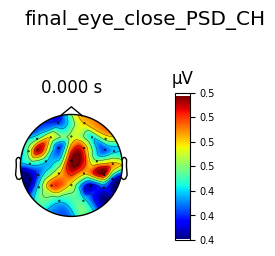

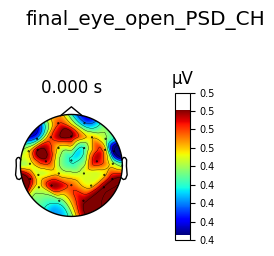

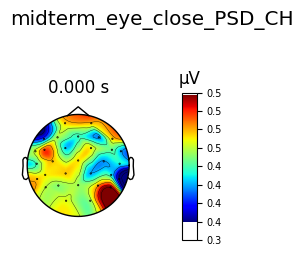

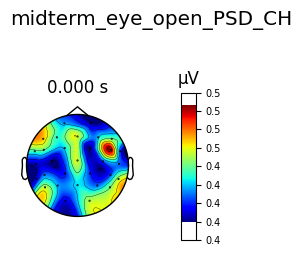

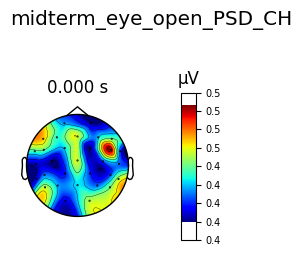

In [52]:
model = 'XGBRegressor'
psd_r2 = pd.read_csv('/data/xiaowei/social_network/HENU/EEG_regression/C30_330_F8_14_N50_E2/' + model + '_r2_score.csv', index_col=0, header=0)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)


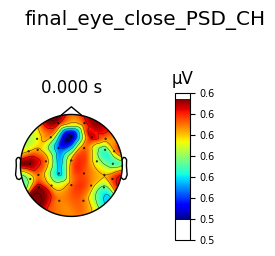

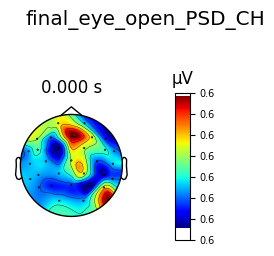

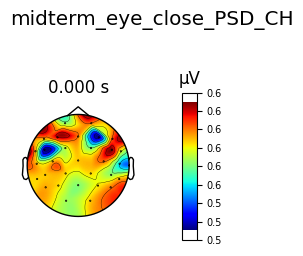

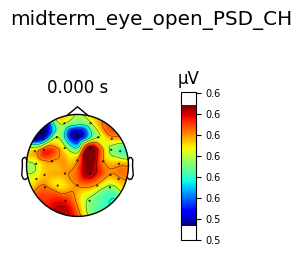

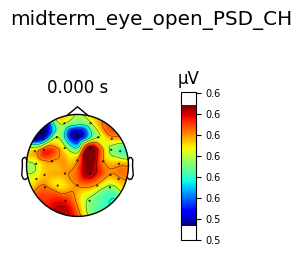

In [54]:
model = 'LinearRegression'
psd_r2 = pd.read_csv('/data/xiaowei/social_network/HENU/EEG_regression/C30_330_F1_40_N50_E2/' + model + '_r2_score.csv', index_col=0, header=0)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)


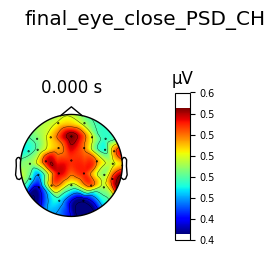

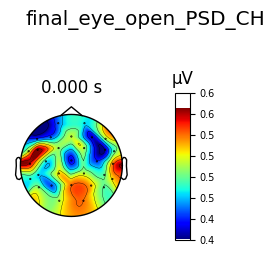

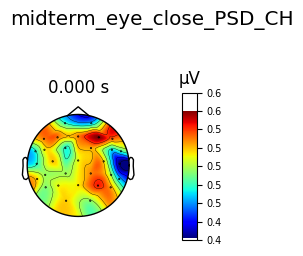

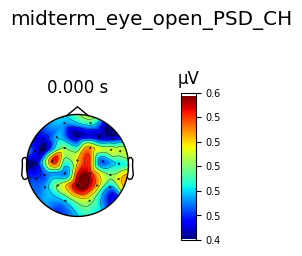

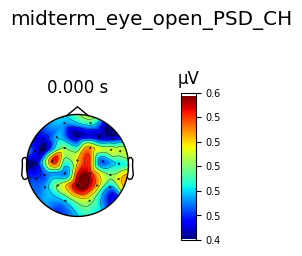

In [56]:
model = 'XGBRegressor'
psd_r2 = pd.read_csv('/data/xiaowei/social_network/HENU/EEG_regression/C30_330_F1_40_N50_E2/' + model + '_r2_score.csv', index_col=0, header=0)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'final_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_close_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)
evoke = epoch['T'].copy().average()
key_index = 'midterm_eye_open_PSD_CH'
evoke._data = np.stack([psd_r2['value'][key_index+str(i)] for i in range(31)]).reshape(-1,1).repeat(evoke._data.shape[1], axis=1)*1e-6
evoke.plot_topomap([0],vmin = evoke._data.min()*1e6,vmax = evoke._data.max()*1e6,cmap = 'jet',title = key_index)


In [79]:
df = pd.read_excel('/data/xiaowei/social_network/HENU/data/survey_data/Social_network_V2.xlsx', index_col=0, header=0)

a = df.to_numpy().reshape(-1)

from sklearn.metrics import r2_score
import torch
print(np.unique(a, return_counts=True))
r2 = r2_score(a, np.ones_like(a)*a.mean())
print(r2)
print(1262/np.sum(np.unique(a, return_counts=True)[1]))


(array([1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1262,  203,  140,  193,  307,  352,  343,  170,   54]))
0.0
0.4173280423280423


In [ ]:
path = '/data/xiaowei/social_network/HENU/EEG_regression/C30_330_F1_40_N50_E2/LinearRegression_final_eye_close_PSD_CH0_model.pkl'